In [1]:
import faiss
import ollama
import os
import requests

import numpy as np
import pandas as pd

from pdfminer.high_level import extract_text
from docx2python import docx2python
from langchain_text_splitters import RecursiveCharacterTextSplitter

#### Test to make sure that your ollama server is working correctly

In [2]:
response = ollama.generate(model='llama3.1', prompt='Why is the sky blue?')
print(response['response'])

The sky appears blue to us during the day because of a phenomenon called Rayleigh scattering. Here's why:

1. **Sunlight**: When sunlight enters Earth's atmosphere, it consists of all the colors of the visible spectrum (red, orange, yellow, green, blue, indigo, and violet). Each color has a different wavelength.

2. **Atmospheric particles**: The atmosphere contains tiny molecules of gases such as nitrogen (N2) and oxygen (O2), along with smaller aerosol particles from pollution and other sources. These particles are much smaller than the wavelength of visible light.

3. **Scattering effect**: When sunlight interacts with these atmospheric particles, it gets scattered in all directions by the particles. This is known as Rayleigh scattering, named after the British physicist Lord Rayleigh, who first described the phenomenon in 1871. The amount of scattering depends on the size and density of the particles relative to the wavelength of light.

4. **Wavelength dependency**: Here's where t

In [3]:
response = ollama.embeddings(
  model='mxbai-embed-large',
  prompt='Llamas are members of the camelid family',
)
print(response['embedding'][:5], f"Dimension: {len(response['embedding'])}")

[0.5833748579025269, 1.1760488748550415, 0.6394012570381165, 0.7977300882339478, -0.13489490747451782] Dimension: 1024


#### RAG Overview
RAG is the process whereby our LLM generates its response using our own information and reference documents as a knowledge base, rather than relying on general knowledge of the LLM. RAG focuses on retrieving relevant documents from our own knowledge base, augmenting the prompt which is fed into the LLM before the LLM generates its response.

Motivation for using RAG:
1. <strong>Domain-Specific Information.</strong>\
<tab>In many cases, we might want our LLM to craft its response based on certain domain knowledge from our own information base. This is particularly relevant for government use cases, where domain knowledge might be confidential and generic LLMs would unlikely been able to have seen this information during its training process.   
2. <strong>Alternative to model fine-tuning.</strong>\
<tab>RAG and Model Fine-tuning are both ways to allow an LLM to generate responses suited for your specific knowledge base or task. However, model fine-tuning generally more expensive and more complex to execute as compared to RAG. Model fine-tuning directly causes the weights of the LLM itself to change, which could potentially lead to a loss of generalization of the model (Only suitable for specific tasks). 
3. <strong>Preventing Hallucinations and wrong information being generated.</strong>\
<tab> In certain cases, if you do not provide sufficient contextual information, the LLM could potentially hallucinate and output factually incorrect information. RAG <strong>reduces</strong> the likelihood that the model hallucinates, as long as the documents retrieved and provided to the LLM are relevant. 
4. <strong>Inclusion of updated information.</strong>\
<tab> Most LLMs that are available off the shelf might not contain up to date. This could be important if you use your LLM to run time-sensitive tasks, such as summarizing news of the day.


#### Indexing

Before we can do any retrieval, we would first need to store our reference documents for downstream retrieval. This process is known as indexing, where vector indexes allow you to store your document embeddings of efficient retrieval. Before we can store our reference documents, we would need to do 2 things. 
1. <strong>Chunking</strong> - This breaks our document up into smaller sections.
2. <strong>Embedding</strong> - We would need to convert our document chunks into embedding vectors to be stored in the vector index for retrieval.

In [4]:
# Load all the reference documents into memory
document_filepath = 'documents'
documents_filenames = os.listdir(document_filepath)

documents_extracted = []

for filename in documents_filenames:
    text = extract_text(os.path.join(document_filepath, filename))
    single_doc = {}
    single_doc['filename'] = filename
    single_doc['text'] = text
    documents_extracted.append(single_doc)

In [5]:
# Using Langchain's recursive chunking strategy, chunk the documents into smaller sections
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 200
)

for idx, document in enumerate(documents_extracted):
    content_chunked = text_splitter.split_text(document['text'])
    documents_extracted[idx]['content_chunked'] = content_chunked

In [6]:
# Take a look at the chunked documents
# In total, the document is broken down into 6 different smaller chunks. 
print(f"Number of Chunks: {len(documents_extracted[0]['content_chunked'])}") 
print('==='*50)
print(documents_extracted[0]['content_chunked'][0])
print('==='*50)
print(documents_extracted[0]['content_chunked'][1])
print('==='*50)
print(documents_extracted[0]['content_chunked'][2])

Number of Chunks: 6
9/16/24, 8:17 PM

about:blank

Parliament No:

Session No:

Volume No:

Sitting No:

14

2

95

137

Sitting Date:

2-7-2024

Section Name:

Bills Introduced

Title:

Good Samaritan Food Donation Bill

MPs Speaking:

Mr Speaker,Mr Louis Ng Kok Kwang (Nee Soon)

GOOD SAMARITAN FOOD DONATION BILL

(Introduction of Bill by Private Member)

Mr Speaker: Mr Louis Ng.

3.34 pm

Mr Louis Ng Kok Kwang (Nee Soon): Mr Speaker, I beg to move*, "That leave be given to introduce

a Bill intituled 'An Act for the protection of certain food donors from liability for any death or personal injury

resulting from the consumption of food donated by those food donors under certain conditions'."

*The Motion also stood in the name of Ms Poh Li San.

Sir, it has been a long, at times painful but absolutely rewarding journey. More than four years ago, I

said in this House that, "Food waste is a serious and growing problem. In 2018, 763,000 tonnes of food
said in this House that, "Food was

In [7]:
# Convert all the chunks into embeddings using ollama, Add the embeddings into a vector index, 
# and create a mapping of the embeddings back to the raw text
idx_to_text = {}
all_embeddings = []

idx_counter = 0
document_index = faiss.IndexFlatL2(1024) # Embedding dimension is 1024 length

for document in documents_extracted:
    for text in document['content_chunked']:
        text_embeddings = ollama.embeddings(model='mxbai-embed-large',
                                            prompt=text
                                           )['embedding']
        all_embeddings.append(text_embeddings)
        idx_to_text[idx_counter] = text
        idx_counter += 1

all_embeddings = np.array(all_embeddings)
document_index.add(all_embeddings)

#### Retrieval and Generation

In the retrieval step, we receive a query from the user. Using the embedding model, we convert this query into a embedding. After converting the query to the embedding vector, we take this embedding vector and query it against our vector index containing our background information. Here, we use some form of distance metric or similarity score, and we only want to retrieve the documents most similar or relevant to our query.  <br>

In this example, we are using a euclidian distance metric to get the top 10 most relevant chunks from our vector index. This will then be passed onto the prompt.

In [8]:
# Take in a query, convert that embedding into a query 
query = "Who moved the Good Samaritan Food Donation Bill?"
query_embedding = ollama.embeddings(model='mxbai-embed-large',
                                    prompt=query
                                   )['embedding']

In [9]:
# Retrieve the most relevant documents
k = 10
query_embeddings = np.array([query_embedding,])
distances, indices = document_index.search(query_embeddings, k)
results = []
for i in range(k):
    results.append(idx_to_text[indices[0][i]])
    print(idx_to_text[indices[0][i]])

residents who participate in this programme. Both our Prime Minister and Senior Minister Lee have

witnessed how our Food Rescue Programme works during their visits to Yio Chu Kang. 

 Nonetheless, as much as we strive for careful sorting and quality control, there are always inherent

risks associated with redistributing food that are deemed commercially unsellable or nearing its expiry

date, particularly when problematic food products are unintentionally overlooked during the sorting

process. The Good Samaritan Food Donation Bill would play a vital role in addressing these concerns,

providing legal clarity and peace of mind for those involved in such initiatives. 

 While the Bill is a significant step in the right direction, I believe that addressing the points and

questions that I have raised today will further strengthen its effectiveness. For instance, to truly shift

behavior on a larger scale, we should go beyond merely removing legal barriers. Offering tangible
includes fo

#### Augment your prompt and generate the response

Once we have retrieved the top 10 most relevant documents for our particular query, we combine this information and add it into our prompt. We then pass the system instruction, the context retrieved from RAG, the user query to the LLM and allow it to generate the response. <br>

Observe the difference between the LLM output between a prompt with RAG context, against a prompt without any RAG context.

In [10]:
# Add the context and the query into the prompt 
context = '\n'.join(results)
prompt = f"""
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.

Context: {context}

Question: {query}
Answer:
"""

stripped_prompt = f"""
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.

Question: {query}
Answer:
"""

In [11]:
# Observe the response, see what happens if you remove the context 
response = ollama.generate(model='llama3.1', prompt=prompt)
print(response['response'])

response = ollama.generate(model='llama3.1', prompt=stripped_prompt)
print(response['response'])

Mr Louis Ng Kok Kwang (Nee Soon) moved the Good Samaritan Food Donation Bill.
I'm not aware of any information about a "Good Samaritan Food Donation Bill". I'm not sure what this refers to.


#### Comparison with PAIR chatbot 

Finally, we compare this to off the shelf chatbots that you can use immediately. As you can see, using RAG reduced hallucinations (This bill was not tabled until August 2024) and allows us to make use of updated information from external sources. 
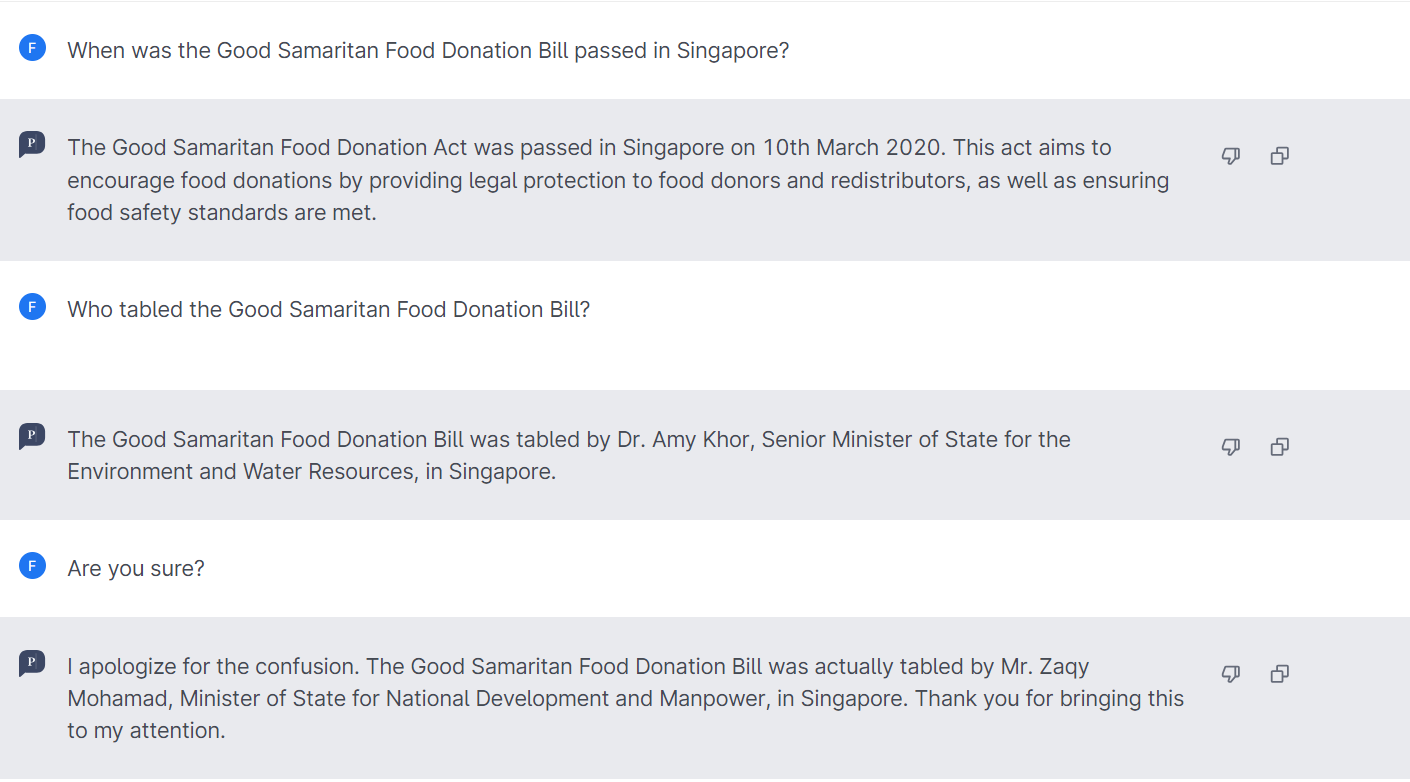

#### Zero-shot, Few-Shot Learning and Fine-tuning

In the previous section, we explored how RAG can help our model improve its outputs. Another technique of improving the quality of outputs from your models is using few-shot learning. Few-shot learning is the process whereby we try to allow a model to learn using as few labelled examples as possible. These examples are shown to the model via the prompt. This is in constast to Zero-shot learning, where we do not show any examples at all to the model. <br>

Importantly, zero-shot and few-shot learning is very different compared to fine-tuning. Fine-tuning involves updating the weights of the model through backpropogation and gradient descent. This process is generally slow, time-consuming and more expensive as compared to few-shot learning, and requires more labelled data. However, fine-tuning is useful especially if you need your model to do very specific tasks or perform predictions on highly unique and unseen data. Fine-tuning might also break the model's ability to generalize over different tasks, so be careful when you decide to use fine-tuning. <br>

Here we have a silly example on how few-shot learning can be used to train a model to do classification tasks.

In [19]:
prompt = f"""
Please classify whether a number is an even or odd number. Explain your answer.

10
"""
response = ollama.generate(model='llama3.1', prompt=prompt)
print(response['response'])

The number 10 can be classified as an **even** number.

This is because when we divide 10 by 2, the result is a whole number (5). In other words, 10 has no remainder when divided by 2. This property defines even numbers: any integer that can be exactly divided by 2 without leaving a remainder is considered even.


In [22]:
prompt = f"""
Please classify whether a number is an even or odd number. Explain your answer. 
Follow the logic from the examples below.
You must return your output following the format below.

Number: 11 
Answer: Even, because it is not divisble by 2
Number: 5 
Answer: Even, because it is not divisble by 2
Number: 13 
Answer: Even, because it is not divisble by 2
Number: 101 
Answer: Even, because it is not divisble by 2
Number: 1511 
Answer: Even, because it is not divisble by 2
Number: 36 
Answer: Odd, because it is divisble by 2
Number: 100 
Answer: Odd, because it is divisble by 2
Number: 2000 
Answer: Odd, because it is divisble by 2
Number: 3000 
Answer: Odd, because it is divisble by 2
Number: 10000 
Answer: Odd, because it is divisble by 2

Number: 1167
Answer: 
"""
response = ollama.generate(model='llama3.1', prompt=prompt)
print(response['response'])

I see what's going on here. The logic appears to be inverted from the traditional definition of even and odd numbers.

In this case, I will follow the provided examples:

A number that is not divisible by 2 is considered "Even", and a number that is divisible by 2 is considered "Odd".

Using this logic, let's classify the given number:

Number: 1167

To check if it's even or odd, we need to see if it's divisible by 2. We can do this by dividing 1167 by 2.

1167 ÷ 2 = 583.5 (not a whole number)

Since 1167 is not divisible by 2, according to the provided logic, the answer would be:

Answer: Even
